# Housing calculations Notebook
First import all desired packages below.

In [3]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Mortgage calculation
define the model where the change in the principle is compounded monthly by r/12 and the monthly mortgage paid is $$ \frac{dp}{dt} = \frac{r}{12} * p - m $$, where $p$ is the principal owed, $t$ is time, $r$ is the apr (it's divided by 12 to get the monthly rate of interest), and $m$ is the mortgage payment. Since these values are updated monthly, the function can be considered continuous.

### Define the initial state of the mortgage 
The initial value of the house (val), the fraction down payment you put down (down), and the number of years on the loan (years), and the APR/rate (rate). From this we can calculate the initial principal ($P_{in} = val - (down * val)$).

In [4]:
# value of house
val = 150000
# fraction down payment
down = 0.05
# initial mortgage
p0 = val - (down * val)

# APR 
r = 3.75 

# length of mortgage converted to months
years= 30
monthes = years * 12

### Define the differential equation to be solved.
Using a differential equation where the inputs are the principal, time, and rate we can calculate the mortgage over time. The rate will be divided by 1200 because we need to convert it from a percent to decimal as well as from yearly to montly rate. Then the mortgage payment will be calculated from the standard fixed rate mortgage equation. The change in the principal will just be simply the difference between the growth of the loan from interest minus the mortgage payment.

In [5]:
def amort(p,t,r):
    r = r/1200
    m = p0 * (r * (1+r) ** monthes)/((1+r) ** monthes -1)
    dpdt = (r) * p - m
    return(dpdt)

To work the differential calculation, we need to define the time over the length of the loan, which is achieved by creating a regular spacing over the total number of monthes of the loan.

In [6]:
t = np.linspace(0,monthes)
p = odeint(amort, p0, t, args= (r,))
p = np.reshape(p, t.shape)

The we can convert the amount owed into a percent equity by dividing the principal owed currently by the original loan amount. This can then be converted into an equity by accounting for the appreciation of the house 

In [7]:
#percent equity
p_eq = down + ((1-down) * (1- (p/p0)))
# yearly appreciation is usually between 3-5%
app_yearly=0.03
app_monthly=app_yearly/12

# percent growht from interest
p_growth = (1+ app_monthly) ** t
# equity
eq = (p_eq * val)
eq_w_app = eq * p_growth

## Visualize the amortization of the loan as well as the growth of equity.

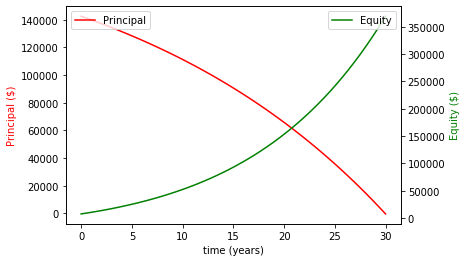

In [8]:
fig,ax = plt.subplots(1,1)
ax.plot(t/12,p, label = "Principal", color = 'red')
ax.set_xlabel('time (years)')
ax.set_ylabel('Principal ($)', color = 'red')
ax2= plt.twinx()
ax2.plot(t/12,eq_w_app, label="Equity", color = 'green')
ax2.set_ylabel('Equity ($)', color = 'green')
ax2.legend(loc = 1)
ax.legend(loc = 2)
plt.show()

# Determine the CoC vs Rent vs Down
Along with the property value estimate the amount of rehab that needs to be done immediately, create an array of down payments ranging from 0\% to 100\%, and from the calculate the size of the mortgages that would happen as well as the rsulting mortgage payments

In [9]:
Prop_val  = 150000
Rehab     = 1500
Other_exp = 0
Closing   = 0.03* 150000
rate      = 3.75
rate      = rate / 1200
downs     = np.linspace(0,0.2, 21)
loans     = Prop_val - (downs * Prop_val)
mortgages = loans * (rate * (1 + rate) ** monthes) / ((1 + rate ) ** monthes -1)

## Estimate the monthly costs of the house
Create an array of possible expenses for the house based off of the static expenses and possible mortgages

In [10]:
Tax  = 200
Insurance = 60
Utilities= 200
HOA =0
Lawn_snow = 0
Repairs= 0 # 100
Capex = 100
Manager = 0 # 100
PMI = 60
Expenses   = Tax + Insurance + Utilities + HOA + Lawn_snow + Repairs + Capex + Manager + mortgages + PMI

## Estimate the rent
Create an array of possible rent values spanning from just being able to cover the monthly expenses of the lowest estimation of the cost of the house to covering the max estimation of the house plus 50\%.

In [11]:
rents     = np.linspace(Expenses.min(), Expenses.max() * 1.5, 41)

## Create a 3-D estimation of the cash flow vs. the Down payment and the rent charged
This should show a gradient from the bottom left to the top right because as the down payment gets larger, the mortgage payment gets smaller and as the rent goes up obviously the more money the property will be earning. (The max and min values should be less than 2000)

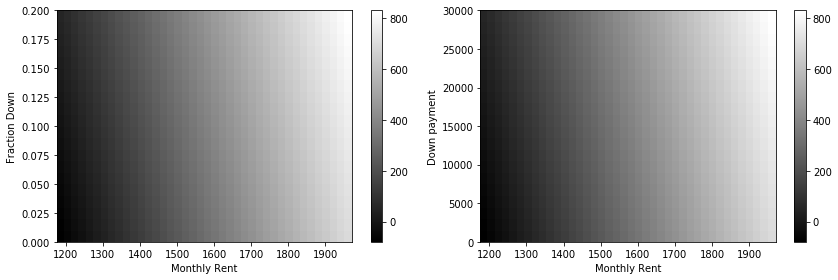

In [12]:
# Generate 2-D arrays from rents and downs arrays: RENT, DOWN
fig = plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
RENT, DOWN = np.meshgrid(rents,downs)
FLOW = RENT - (Tax + Insurance + Utilities + HOA + Lawn_snow + Repairs + Capex + Manager + ((Prop_val - (DOWN * Prop_val)) * (rate * (1 + rate) ** monthes) / ((1 + rate ) ** monthes -1)))
# Display the resulting image with pcolor()
plt.xlabel('Monthly Rent')
plt.ylabel('Fraction Down')

plt.pcolor(RENT, DOWN, FLOW, cmap = 'gray')
plt.colorbar()
plt.axis('tight')
# plot 2 
plt.subplot(1,2,2)
plt.xlabel('Monthly Rent')
plt.ylabel('Down payment')

plt.pcolor(RENT, DOWN * Prop_val, FLOW, cmap = 'gray')
plt.colorbar()
plt.axis('tight')

plt.tight_layout()

plt.show()

# Highlight Cash on Cash returns of interest for reference.
Here I've highlighted 0, 10, 15, and 20 percent returns for reference.

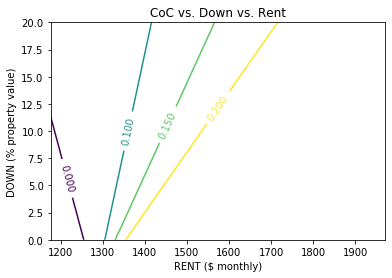

In [13]:
# Generate 2-D arrays from u and v: X, Y
RENT,DOWN = np.meshgrid(rents,downs)
FLOW = (RENT -
        (Tax + Insurance + Utilities + HOA + Lawn_snow + Repairs + Capex + Manager + ((Prop_val - (DOWN * Prop_val)) * (rate * (1 + rate) ** monthes) / ((1 + rate ) ** monthes -1))))


# Plot 2
CoC = (((RENT -
        (Tax + Insurance + Utilities + HOA + Lawn_snow + Repairs + Capex + Manager + 
         ((Prop_val - (DOWN * Prop_val)) * (rate * (1 + rate) ** monthes) / ((1 + rate ) ** monthes -1))))* 12) /
       ((DOWN * Prop_val) + Closing + Rehab + Other_exp))
fig, ax = plt.subplots()
CS = ax.contour(RENT, DOWN * 100, CoC, levels = [0, 0.1, 0.15, 0.2])
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('CoC vs. Down vs. Rent')
plt.xlabel('RENT ($ monthly)')
plt.ylabel('DOWN (% property value)')
plt.show()

## Determine the optimal rent to make a minimal down payment I calculated and visualized the gradients

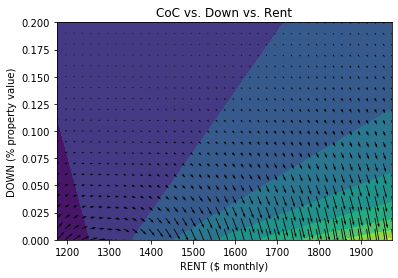

In [14]:
plt.subplots()
plt.title('CoC vs. Down vs. Rent')
plt.xlabel('RENT ($ monthly)')
plt.ylabel('DOWN (% property value)')

yd, xd = np.gradient(CoC)
plt.contourf(RENT, DOWN, CoC)
plt.quiver(RENT, DOWN, xd, yd)

plt.show()

# Experimental Section
This section aimed To determine the exact value for the rent to make sure that a minimal down payment is optimal I found the inflection point at which the gradient turned negative with respect the Down payment.

In [15]:
# the shape of the gradient matrix is (21, 41) : (Downs, rents). since the inflection occurs across the 
# x variable (Rent) we can just look at the number of points that are greater than zero. Since the first point that is 
# less than zero is the inflection 
yd.shape

(21, 41)

In [16]:
rentind = []
for rent in yd :
    rentind += [np.sum(rent > 0)]
# Average overall all down payments in case of covariance

rentind = int(np.mean(rentind))

In [17]:
# Calculate the total rent to acheive the optimization
print('Total rent: ${}'.format(int(rents[rentind])))
print('Rent per 3 rooms: ${}'.format(int(rents[rentind]/3)))
CoC = (((rents[rentind] -
        (Tax + Insurance + Utilities + HOA + Lawn_snow + Repairs + Capex + Manager + 
         ((Prop_val - (0.02 * Prop_val)) * (rate * (1 + rate) ** monthes) / ((1 + rate ) ** monthes -1))))* 12) /
       ((0.02 * Prop_val) + Closing + Rehab + Other_exp))
print('Cash on Cash returns: {} %'.format(CoC * 100))
FLOW = (rents[rentind] -
        (Tax + Insurance + Utilities + HOA + Lawn_snow + Repairs + Capex + Manager + ((Prop_val - (0.02 * Prop_val)) * (rate * (1 + rate) ** monthes) / ((1 + rate ) ** monthes -1))))
print('Monthly cash flow: ${}'.format(FLOW))

Total rent: $1295
Rent per 3 rooms: $431
Cash on Cash returns: 7.253266126418143 %
Monthly cash flow: $54.399495948136064


In [18]:
# Calculate the CoC based on rent
rent = 1200
print('Total rent: ${}'.format(rent))
print('Rent per 3 rooms: ${}'.format(int(rent/3)))
CoC = (((rent -
        (Tax + Insurance + Utilities + HOA + Lawn_snow + Repairs + Capex + Manager + 
         ((Prop_val - (0.02 * Prop_val)) * (rate * (1 + rate) ** monthes) / ((1 + rate ) ** monthes -1))))* 12) /
       ((0.02 * Prop_val) + Closing + Rehab + Other_exp))
print('Cash on Cash returns: {} %'.format(CoC * 100))
FLOW = (rent -
        (Tax + Insurance + Utilities + HOA + Lawn_snow + Repairs + Capex + Manager + ((Prop_val - (0.02 * Prop_val)) * (rate * (1 + rate) ** monthes) / ((1 + rate ) ** monthes -1))))
print('Yearly cash flow: ${}'.format(FLOW * 12))

Total rent: $1200
Rent per 3 rooms: $400
Cash on Cash returns: -5.437322614803027 %
Yearly cash flow: $-489.35903533227247
